This module focuses on linear discriminant analysis (LDA).  Use LDA when the 
dependent is categorical and independents are continuous.  Use
ANOVA when the situation is reversed.  It requires that the IVs are normally
distributed (not the case for logistical regression and probit.
   
The LDA is a form of Bayesian classification.  It models the membership in 
each class:

   P(X|y=k)
   
 ...as a multivariate Gaussian distribution.  X is the IV vector, y is the DV,
    k is the class.  Using Bayes' transformation, we can use priors:
    
    [ P(X|y=k) * P(y=k) ] / [ SUM_over_i { P(X|y=i) * P(y=i)  } ]
 
 Full description here: http://scikit-learn.org/stable/modules/lda_qda.html

In [111]:
#py_pandas_lda_1.ipynb
import numpy as np             
import pandas as  pd    
import os
import scipy
import matplotlib.pyplot as plt #data visualization
import seaborn as sns
import matplotlib.dates as dates #date munging
import csv
import datetime
import math
%matplotlib inline

if '__file__' in dir():
    path, _=os.path.split(__file__)  
else: path=os.getcwd() 

datafile='iris.data.csv'  #Fisher's classic
filename=os.path.join(path, datafile)


In [112]:
#create a DataFrame object
df=pd.read_csv(filename)

#dependent and independent variables
iv_names=['slength', 'swidth', 'plength', 'pwidth']
dv_name='iclass'

#take a look at the data
df.describe()

,slength,swidth,plength,pwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [113]:
df.head(3)

,slength,swidth,plength,pwidth,iclass
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [114]:
#create categorical data descriptions
auto_cats=pd.Categorical(df['iclass'])
auto_cats.describe()

,counts,freqs
categories,,
Iris-setosa,50,0.333333
Iris-versicolor,50,0.333333
Iris-virginica,50,0.333333


In [115]:
#add the categorical codes as a new column
df['iclass_ix']=auto_cats.codes
df.head(2)

,slength,swidth,plength,pwidth,iclass,iclass_ix
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0


In [116]:
df.tail(2)

,slength,swidth,plength,pwidth,iclass,iclass_ix
148,6.2,3.4,5.4,2.3,Iris-virginica,2
149,5.9,3.0,5.1,1.8,Iris-virginica,2


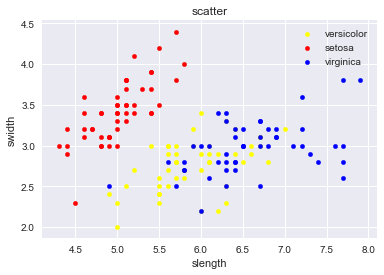

In [117]:
#have a look at sepal / petal length scatter using  df.plot.scatter() 
ax=df[df.iclass=='Iris-versicolor'].\
    plot.scatter(x='slength', y='swidth', 
                 color='yellow', label='versicolor') 

df[df.iclass=='Iris-setosa'].\
    plot.scatter(x='slength', y='swidth', 
                 color='red', label='setosa',
                 ax=ax)   #use same axes object!

df[df.iclass=='Iris-virginica'].\
    plot.scatter(x='slength', y='swidth', 
                 color='blue', label='virginica', 
                 ax=ax)    #here, too.

ax.set_title("scatter") 
#ax.figure

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018575828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001978B080>]], dtype=object)

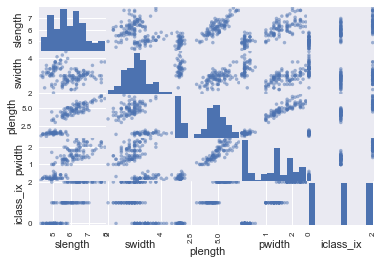

In [118]:
#You can also "throw the spaghetti against the wall" and look
#  at all the scatters and some summary data:
pd.plotting.scatter_matrix(df)

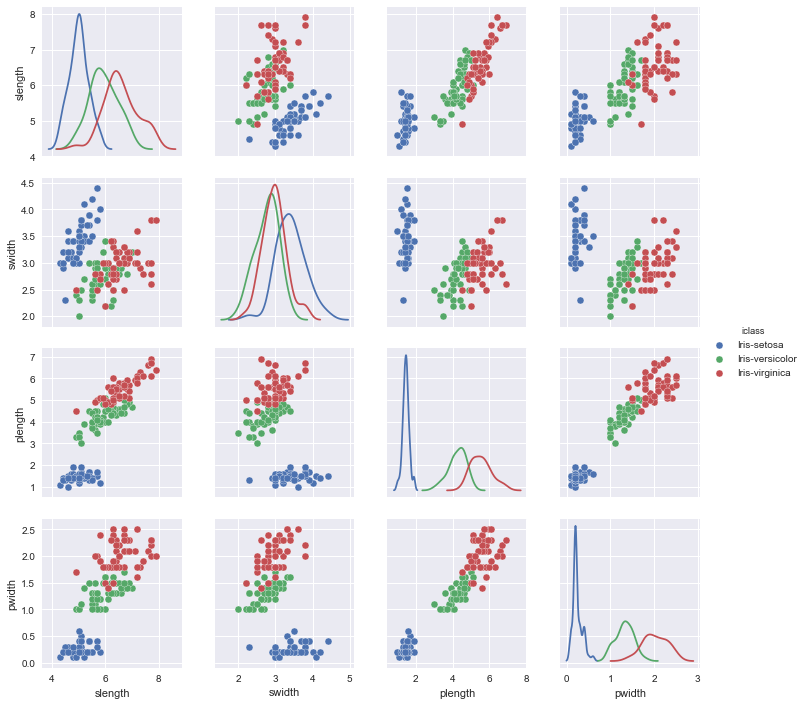

In [119]:
#here is Seaborn's rendition
sns.set()
sns.pairplot(df[['slength', 'swidth', 'plength', 'pwidth', 'iclass']],
                 hue="iclass", 
                 diag_kind="kde")

In [120]:
#Tests for distribution (should be normal)
#  This uses D'Agostino's K-squared:
#     skew_test_z-score ^2 + kurtosis_test_z-score ^2
#  
#  Test loooks for chi^2 distro w/ 2 df - asks 'is shape about right?'
#     H0: distribution is normal  (this is the "null hypothesis")

p_target=.05   #if the p-value is less that this, we fail the test

for iv in iv_names:
    data=df[iv]	
    statistic, p =scipy.stats.normaltest(data)
    if p<p_target:
        result='FAILED. SAD!'
    else: result='passed'
    print("\tfeature: {:<10} {:<20} p={:<10}".\
          format(iv, result, round(p,2)))

	feature: slength    passed               p=0.06      
	feature: swidth     passed               p=0.17      
	feature: plength    FAILED. SAD!         p=0.0       
	feature: pwidth     FAILED. SAD!         p=0.0       


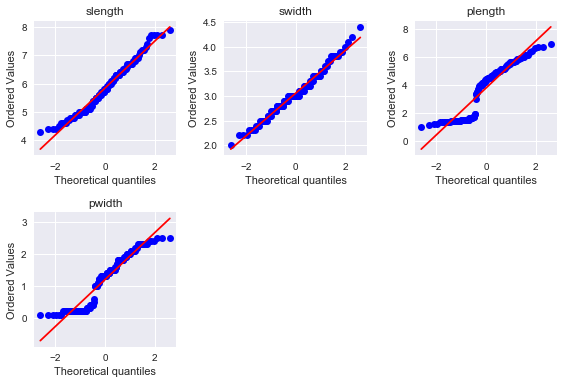

In [121]:
#Some visuals ... build up the subplot objects analytically - 
#loop over our data vectors and create Q-Q charts for each

#create a plot object
plt.figure()

#set up the rows/columns for our plot object
cols=3
rows=math.ceil(len(iv_names)/cols) 

row=1; col=1; subplot=1
for iv in iv_names:    
    data=df[iv]	                           #grab the data
    plt.subplot(rows, cols, subplot)       #create the subplot object
    scipy.stats.probplot(data, plot=plt)   #stuff it w/ data
    plt.title(iv)                          #give it a nice title
    #reset indices 
    col+=1
    if col>cols: 
        col=1
        row+=1
    subplot+=1

#spruce it up aesthetically 
fig=plt.gcf()   #get current figure - figure object is main container
fig.canvas.set_window_title("Q-Q Charts")
plt.tight_layout() #alternative:  plt.subplots_adjust() 

In [122]:
#Lookin' good.  Let's do some analysis

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#grab the descriptive data
raw_data = df[iv_names].values  #a ndarray

#create an instance of LDA.  We'll use this object to run
#  analysis, test results, store the solved model.
lda = LDA(n_components=2)
lda

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [135]:
#use fit() to produce component vectors and transform() to project
iclass_ix=pd.Categorical(df[dv_name]).codes

#lda.fit(<independent vars, dependent var>)
lda_result=lda.fit(raw_data, iclass_ix)    #fit the data
lda_result=lda_result.transform(raw_data)  #projection to [x,y]

#add results to the DataFrame for future reference
df['dim1'] = lda_result[:, 0]
df['dim2'] = lda_result[:, 1]

#not much to look at, but here are the results
lda_result[:3]

array([[-8.0849532 ,  0.32845422],
       [-7.1471629 , -0.75547326],
       [-7.51137789, -0.23807832]])

In [124]:
#so, how did we do?  
mean_success_rate=lda.score(raw_data, iclass_ix)
print("Success rate:", round(mean_success_rate, 2))

Success rate: 0.98


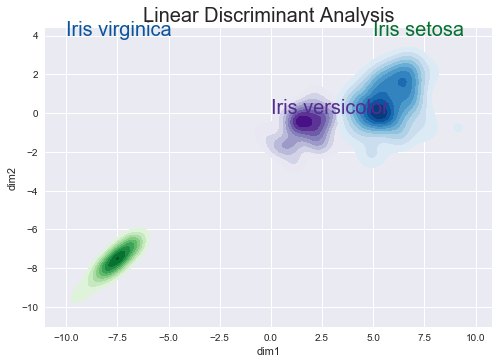

In [125]:
#make a nice plot of the results

#query for the separate iris classes
setosa = df.query("iclass=='Iris-setosa'")
versicolor = df.query("iclass=='Iris-versicolor'")
virginica = df.query("iclass=='Iris-virginica'")

#create a new plotting object and load it with KDE (kernel 
#   density estimate) plots
plt.figure()

#these are color pallattes known to seaborn (lots of other options)
color1="Greens"; color2="Purples"; color3="Blues"

ax = sns.kdeplot(setosa.dim1, setosa.dim1, cmap=color1,
                 shade=True, shade_lowest=False)
ax = sns.kdeplot(versicolor.dim1, versicolor.dim2, cmap=color2,
                 shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.dim1, virginica.dim2, cmap=color3,
                 shade=True, shade_lowest=False)

#create some labels; this picks off the darkest color of each palatte
color1 = sns.color_palette(color1)[-1]
color2 = sns.color_palette(color2)[-1]
color3 = sns.color_palette(color3)[-1]

#this places text (x, y, text, color, font size)
ax.text(5, 4, "Iris setosa", color=color1, size=20)
ax.text(0, 0, "Iris versicolor", color=color2, size=20)
ax.text(-10, 4, "Iris virginica", color=color3, size=20)

#second arg is a dict that can contain lots of font specs
ax.set_title('Linear Discriminant Analysis', {'fontsize':20})


In [126]:
#Now try on a training set (we'll split it in half)

#sklearn.cross_validation.rain_test_split in older versions
from sklearn.model_selection import train_test_split

#could do this manually, but it's built-in.  ".5" makes a 50/50 split
train, test=train_test_split(df, test_size=.5)

train_data = train[['slength', 'swidth', 'plength', 'pwidth']].values
train_class_ix=train['iclass_ix']

test_data = test[['slength', 'swidth', 'plength', 'pwidth']].values
test_class_ix=test['iclass_ix']



In [127]:
#analyze the training data
lda = LDA(n_components=2)

#use fit() to produce component vectors
train_result=lda.fit(train_data, train_class_ix)
tlda_result=train_result.transform(train_data)

#show the results  
train_success_rate=train_result.score(train_data, train_class_ix)
print("Training success rate:", round(train_success_rate, 2))


Training success rate: 0.97


In [128]:
#This time using test data against trained model
test_success_rate=train_result.score(test_data, test_class_ix)
print("Test success rate ('naive' data):", round(test_success_rate, 2))

Test success rate ('naive' data): 0.97


In [129]:
#just for fun, play around with the size of the training set
results=[]
for training_frac in [.10,.20,.30,.40,.50]:
    train, test=train_test_split(df, test_size=training_frac)
    lda = LDA(n_components=2)
    
    train_data = train[['slength', 'swidth', 'plength', 'pwidth']].values
    train_class_ix=train['iclass_ix']
    
    test_data = test[['slength', 'swidth', 'plength', 'pwidth']].values
    test_class_ix=test['iclass_ix']
    
    #use fit() to produce component vectors
    train_result=lda.fit(train_data, train_class_ix)
    tlda_result=train_result.transform(train_data)
    
    #so, how did we do?  This time using test data against trained model
    test_success_rate=train_result.score(test_data, test_class_ix)
    results.append((training_frac, test_success_rate))

print("results from changing training fraction")
print("YMMV as the training set is randomly drawn\n")
fmt="{:<10} {:<10}"
print(fmt.format("fraction", "score"))
print(fmt.format("_"*10, "_"*10))
print()

for frac, result in results:
    print(fmt.format(frac, round(result,2)))


results from changing training fraction
YMMV as the training set is randomly drawn

fraction   score     
__________ __________

0.1        0.93      
0.2        1.0       
0.3        1.0       
0.4        0.93      
0.5        1.0       


In [130]:
#you can pickle a saved model and rerun it intact:
import pickle

fn='my_lda_model.pkl'
model=train_result

#serialize and store
with open(fn, 'wb') as f:
    pickle.dump(model,f)

#kill the original     
model=None

#reconstitute the Python object
with open(fn, 'rb') as f:
    model=pickle.load(f)
    
print("recovered model\n", repr(model))

print("Same score?")
reconstituted = model.score(test_data, test_class_ix)
original = train_result.score(test_data, test_class_ix)
print("original: {}   reconstituted: {}".\
        format(original, reconstituted))


recovered model
 LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
Same score?
original: 1.0   reconstituted: 1.0
